<a href="https://colab.research.google.com/github/jumafernandez/clasificacion_correos/blob/main/notebooks/jaiio/03-modelos/03-tfidf%2Bsvm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TF-IDF+SVM

En esta notebook se presetan los experimentos a partir de los datos etiquetados automáticamente a partir de las _features_ extraidas del train dataset con la estrategia de TF-IDF y SVM.

Para ello vamos a preprocesar los correos y aplicar:
- Bag of words,
- Pesado binario/no binario,
- Máquina de vector soporte (SVM).


## 1. Instalación y Carga de librerías y funciones útiles

### 1.1 Instalación de librerías

Se instalan las librerías que no están en el entorno de Google Colab:

In [1]:
# Se instala gensim que es el que tiene el modelo Word2Vec
!pip install requests
!pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=378424de7052d845c803470762d56129bc1f1daa744799e25f5b88955332f65c
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


### 1.2 Funciones útiles

Se cargan funciones útiles desde el repo https://github.com/jumafernandez/clasificacion_correos para la carga y balanceo del dataset.

In [2]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_dataset.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_dataset.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_dataset import get_clases, cargar_dataset, consolidar_df

También se carga la función para preprocesar el texto que se usó en los otros modelos desde el repo: https://github.com/jumafernandez/clasificacion_correos.

In [3]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_preprocesamiento.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_preprocesamiento.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_preprocesamiento import preprocesar_correos

### 1.3. Carga de datos

Se carga el dataframe en memoria con el preprocesamiento de los datos:

In [4]:
import warnings
from os import path
warnings.filterwarnings("ignore")

# Constantes con los datos
DS_DIR = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/data/50jaiio/consolidados/'
TRAIN_FILE = 'dataset-tfidf-200-boosting-prep.csv'
TEST_FILE = 'correos-test-jaiio-20.csv'

# Chequeo sobre si los archivos están en el working directory
download_files = not(path.exists(TRAIN_FILE))

etiquetas = get_clases()

# Defino la cantidad de clases a utilizar
CANTIDAD_CLASES = len(etiquetas)

train_df, test_df, etiquetas = cargar_dataset(DS_DIR, TRAIN_FILE, TEST_FILE, download_files, 'clase', etiquetas, CANTIDAD_CLASES, 'Otras Consultas')

# Se ejecuta el preprocesamiento de correos sobre el campo Consulta de train y test
import pandas as pd
train_df['consulta'] = pd.Series(preprocesar_correos(train_df['consulta']))
test_df['consulta'] = pd.Series(preprocesar_correos(test_df['consulta']))

# Muestro salida por consola
print('Existen {} clases: {}.'.format(len(train_df.clase.unique()), train_df.clase.unique()))

Se inicia descarga de los datasets.

El conjunto de entrenamiento tiene la dimensión: (1600, 25)
El conjunto de testeo tiene la dimensión: (200, 24)
Existen 16 clases: ['Boleto Universitario' 'Cambio de Carrera' 'Cambio de Comisión'
 'Consulta por Equivalencias' 'Consulta por Legajo'
 'Consulta sobre Título Universitario' 'Cursadas' 'Datos Personales'
 'Exámenes' 'Ingreso a la Universidad' 'Pedido de Certificados'
 'Problemas con la Clave' 'Reincorporación' 'Requisitos de Ingreso'
 'Simultaneidad de Carreras' 'Situación Académica'].


### 1.4 Selección de Instancias

Se seleccionan las instancias en función del _score_:

In [5]:
#train_df = train_df.query('score>20').reset_index()

Y también pueden seleccionarse en función de la cantidad por clase:

In [6]:
N = 100

if N<200:
  train_df = train_df.groupby('clase').head(N).reset_index(drop=True)

In [7]:
count_train = train_df.clase.value_counts().sort_index()

count_train.index

Index(['Boleto Universitario', 'Cambio de Carrera', 'Cambio de Comisión',
       'Consulta por Equivalencias', 'Consulta por Legajo',
       'Consulta sobre Título Universitario', 'Cursadas', 'Datos Personales',
       'Exámenes', 'Ingreso a la Universidad', 'Pedido de Certificados',
       'Problemas con la Clave', 'Reincorporación', 'Requisitos de Ingreso',
       'Simultaneidad de Carreras', 'Situación Académica'],
      dtype='object')

Me guardo la columna del score de Elasticsearch para no generar incompatibilidades:

In [8]:
score = train_df['score']
train_df.drop(['score'], inplace=True, axis=1)

train_df.shape

(1600, 24)

## 2. SVM

### 2.1. Carga de librerías de procesamiento de texto

Se cargan en memoria dos funciones: _grid_search_por_estrategia_representacion_ que va a iterar ajustando los hiperparámetros para las técnica de __SVM__ y _representacion_documentos_ que genera representaciones para las _features textuales_:

In [9]:
import requests

# Se hace el request del raw del script python
url = 'https://raw.githubusercontent.com/jumafernandez/clasificacion_correos/main/scripts/funciones_clasificacion_texto.py'
r = requests.get(url)

# Se guarda en el working directory
with open('funciones_clasificacion_texto.py', 'w') as f:
    f.write(r.text)

# Se importan las funciones a utilizar
from funciones_clasificacion_texto import gridsearch_por_estrategia_representacion, representacion_documentos

### 2.2 Modelo general (clasificación en las 16 clases)

En primer lugar se trabaja con un único clasificador que clasifica y testea las instancias en las 16 clases posibles.

#### 2.2.1 Definición del espacio de búsqueda

Se define el espacio de búsqueda para el ajuste de hiperparámetros del modelo:

In [10]:
# Defino una lista con los esquemas de representación
estrategias_representacion = ['3-4-NGRAM-CHARS', '1-2-NGRAM-WORDS']
modelo = 'SVM'

# Defino los parámetros para GridSearchCV
params_svm = {'SVM__C': [0.1, 1, 10, 100], 
              'SVM__gamma': [0.01, 0.1, 1],
              'SVM__class_weight': [None, 'balanced'],
              'SVM__kernel': ['rbf', 'linear', 'poly', 'sigmoid']
              }

Se ejecuta el ajuste de hiperparámetros para cada estrategia de representación en función del espacio de búsqueda:

In [11]:
NO_CORRIDA = False

if NO_CORRIDA:
  for estrategia in estrategias_representacion:
    # Llamo a la función que realiza el gridsearch por estrategia  
    gridsearch_por_estrategia_representacion(train_df, test_df, estrategia, modelo, params_svm, None, atr_consulta='consulta')

#### 2.2.2 Modelo generado

En función de los mejores hiperparámetros encontrados con la búsqueda Grid, ajusto el modelo para obtener las métricas (por un bug en la función ya solucionado):

In [12]:
# Mejores Parámetros según GridSearchCV:
# DOCS = 200, boosting
# Parámetros: Parámetros: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 
# 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.74, 'precision': 0.6004699248120301,
# 'recall': 0.6847894888530615, 'f1_score': 0.598663821952355}
# DOCS = 100, boosting, accuracy: 0.69
# Parámetros: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.69, 'precision': 0.6011043643856144, 'recall': 0.6518977316066847, 'f1_score': 0.566446113504937}
# DOCS = 50, boosting, accuracy: 0.64
# DOCS = 20, boosting, accuracy: 0.55
# DOCS = 100, accuracy: 0.67
# DOCS = 50, accuracy: 0.63
# DOCS = 20, accuracy: 0.56
# DOCS = 100, NOT boosting Parámetros: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.1, 'SVM__kernel': 'sigmoid', 'clasificador': 'SVM', 'estrategia': 'TFIDF', 'accuracy': 0.68, 'precision': 0.5236766751158198, 'recall': 0.5970173705013522, 'f1_score': 0.5222067737005347}

params_svm = {'SVM__C': [1], 
              'SVM__gamma': [0.01],
              'SVM__class_weight': [None],
              'SVM__kernel': ['sigmoid'],
              'SVM__probability': [True]
              }

clf, X_test, y_test = gridsearch_por_estrategia_representacion(train_df, test_df, '3-4-NGRAM-CHARS', 'SVM', params_svm, None, atr_consulta='consulta')

Estrategia de representación: 3-4-NGRAM-CHARS
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 11.0min finished


Estrategia de representación: 3-4-NGRAM-CHARS
Parámetros: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.675, 'precision': 0.8294973739495798, 'recall': 0.675, 'f1_score': 0.7193846434885444}
Accuracy Test-Set: 0.675
Métricas sobre Test-Set: {'SVM__C': 1, 'SVM__class_weight': None, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid', 'SVM__probability': True, 'clasificador': 'SVM', 'estrategia': '3-4-NGRAM-CHARS', 'accuracy': 0.675, 'precision': 0.8294973739495798, 'recall': 0.675, 'f1_score': 0.7193846434885444}


Se predicen las instancias de testeo:

In [13]:
y_pred = clf.predict(X_test)

Además, se utiliza el método _predict\_proba_ para calcular la probabilidad asociada a la clasificación de cada instancia:

In [14]:
import numpy as np

y_pred_proba = np.around(clf.predict_proba(X_test), 2)

y_max_proba = np.amax(y_pred_proba, 1)

In [15]:
y_max_proba

array([0.48, 0.27, 0.27, 0.21, 0.27, 0.72, 0.36, 0.39, 0.92, 0.21, 0.93,
       0.18, 0.97, 0.51, 0.75, 0.6 , 0.65, 1.  , 0.94, 0.33, 0.37, 0.48,
       0.38, 0.25, 0.76, 0.24, 0.32, 0.43, 0.81, 0.89, 0.45, 0.7 , 0.81,
       0.99, 0.51, 0.8 , 0.76, 0.72, 0.92, 0.34, 0.7 , 0.31, 0.51, 0.36,
       0.91, 0.6 , 0.32, 0.32, 0.66, 0.25, 0.17, 0.43, 0.95, 0.4 , 0.6 ,
       0.52, 0.71, 0.7 , 0.93, 0.4 , 0.54, 0.98, 0.77, 0.97, 0.49, 0.73,
       0.88, 0.53, 0.83, 0.53, 0.39, 0.99, 0.7 , 0.93, 0.38, 0.46, 0.54,
       0.98, 0.83, 0.89, 0.51, 0.53, 0.64, 0.77, 0.59, 0.98, 0.41, 0.79,
       0.49, 0.9 , 0.82, 0.9 , 0.29, 0.29, 0.78, 0.46, 0.35, 1.  , 0.4 ,
       0.88, 0.92, 0.61, 0.4 , 0.41, 0.82, 0.4 , 0.44, 0.36, 1.  , 0.31,
       0.6 , 0.26, 0.6 , 0.85, 0.99, 0.83, 0.71, 0.83, 0.99, 0.18, 0.36,
       0.24, 0.29, 0.62, 0.99, 0.4 , 0.19, 0.43, 0.64, 0.63, 0.85, 0.56,
       0.67, 0.87, 0.86, 0.84, 0.18, 0.67, 0.86, 0.31, 0.17, 0.25, 0.27,
       0.4 , 0.65, 0.74, 0.54, 0.43, 0.36, 0.74, 0.

Se genera un dataframe con las clases observadas para test, las predicciones y las probabilidades asociadas para verificar si hay relación entre las proba y los errores:

In [16]:
import pandas as pd

resultados = pd.concat([pd.Series(y_test), pd.Series(y_pred), pd.Series(y_max_proba)], axis=1)
resultados.columns = ['clase', 'prediccion', 'max_proba']
resultados['correcto'] = resultados['clase'] == resultados['prediccion']

Se calcula el _accuracy_ para las predicciones con una proba>0.5 y se obtiene una mejora sustancial:

In [17]:
sum(resultados[resultados.max_proba>0.5]['correcto'])/resultados[resultados.max_proba>0.5]['correcto'].count()

0.811965811965812

#### 2.2.3 Métricas de selección

##### 2.2.3.1. Matriz de confusión

A continuación, se calcula la matriz de confusión para cada clase para el recorte con proba>0.5 y para el modelo con la totalidad de instancias:

In [18]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:", metrics.accuracy_score(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(resultados[resultados.max_proba>0.5]['clase'], resultados[resultados.max_proba>0.5]['prediccion']))

Accuracy: 0.811965811965812
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.90      0.95        30
                  Cambio de Carrera       0.33      1.00      0.50         1
                 Cambio de Comisión       1.00      1.00      1.00         1
         Consulta por Equivalencias       1.00      1.00      1.00         2
                Consulta por Legajo       0.40      0.67      0.50         3
Consulta sobre Título Universitario       0.50      1.00      0.67         2
                           Cursadas       0.50      0.56      0.53         9
                   Datos Personales       0.00      0.00      0.00         0
                           Exámenes       1.00      0.67      0.80         3
           Ingreso a la Universidad       0.90      0.64      0.75        14
             Pedido de Certificados       0.93      1.00      0.96        13
             Problemas con la Clave       0.93 

In [19]:
from sklearn import metrics #Importar el módulo metrics de scikit-learn

# Vamos a testear el modelo
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

# Vemos un reporte de clasificación de varias métricas
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.675
                                     precision    recall  f1-score   support

               Boleto Universitario       1.00      0.83      0.91        48
                  Cambio de Carrera       0.07      0.50      0.12         2
                 Cambio de Comisión       0.67      1.00      0.80         2
         Consulta por Equivalencias       1.00      1.00      1.00         3
                Consulta por Legajo       0.20      0.67      0.31         3
Consulta sobre Título Universitario       0.33      1.00      0.50         3
                           Cursadas       0.54      0.68      0.60        19
                   Datos Personales       0.00      0.00      0.00         2
                           Exámenes       0.50      0.60      0.55         5
           Ingreso a la Universidad       0.88      0.42      0.57        33
             Pedido de Certificados       0.94      1.00      0.97        15
             Problemas con la Clave       0.88      0.65   

In [20]:
metrics.confusion_matrix(y_test, y_pred)

array([[40,  1,  0,  0,  0,  2,  1,  2,  0,  0,  0,  0,  1,  0,  1,  0],
       [ 0,  1,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  2,  1, 13,  0,  1,  1,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  5,  0,  0,  3,  1,  3,  3,  1, 14,  1,  1,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  0,  0,  1,  0,  2,  0,  1,  0, 15,  0,  0,  1,  0],
       [ 0,  4,  0,  0,  2,  0,  1,  0,  0,  0,  0,  0,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  1,  5,  0,  0,  0,  0,

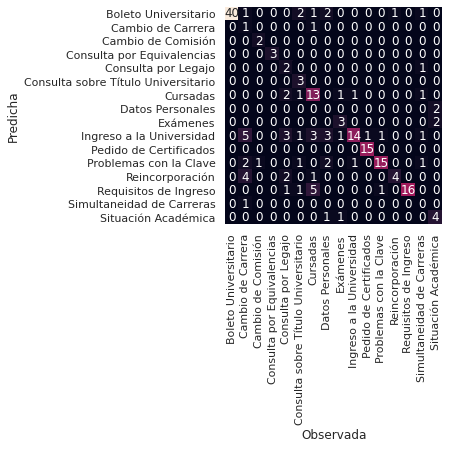

In [21]:
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

mat = metrics.confusion_matrix(y_test, y_pred)

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=etiquetas, yticklabels=etiquetas)

plt.xlabel('Observada')
plt.ylabel('Predicha');

### 3. Análisis del error

A continuación se intenta entender la baja de _accuracy_ para el etiquetado a partir de TF-IDF.

Para ello, se genera el dataset de train con: <br/>
| consulta | clase | score |

In [22]:
df_train_e = train_df[['consulta', 'clase']]
df_train_e['score'] = score

Genero un dataframe con los scores promedios por clase, el accuracy por clase y el _count_:

In [23]:
df_error = df_train_e.groupby(['clase']).mean().reset_index()

# Accuracy por clase
avg_class = mat.diagonal()/mat.sum(axis=1)
df_error['accuracy'] = pd.Series(avg_class)

df_error['count_test'] = mat.sum(axis=1)

df_error['count_train'] = count_train.values

df_error

,clase,score,accuracy,count_test,count_train
0,Boleto Universitario,26.180831,0.833333,48,100
1,Cambio de Carrera,17.207556,0.500000,2,100
2,Cambio de Comisión,22.679662,1.000000,2,100
3,Consulta por Equivalencias,18.025492,1.000000,3,100
4,Consulta por Legajo,18.362995,0.666667,3,100
5,Consulta sobre Título Universitario,18.760835,1.000000,3,100
6,Cursadas,20.738591,0.684211,19,100
7,Datos Personales,16.102668,0.000000,2,100
8,Exámenes,21.347229,0.600000,5,100
9,Ingreso a la Universidad,22.761732,0.424242,33,100


In [24]:
df_error[['accuracy', 'score']].corr()

,accuracy,score
accuracy,1.000000,0.415771
score,0.415771,1.000000


In [25]:
GUARDA_ACC = True

if GUARDA_ACC:
  from google.colab import drive
  drive.mount('drive')

  df_error.to_csv('accuracy_by_class-tfidf.csv', index=False)
  !cp accuracy_by_class-tfidf.csv "drive/My Drive/jaiio-prep/"

Mounted at drive


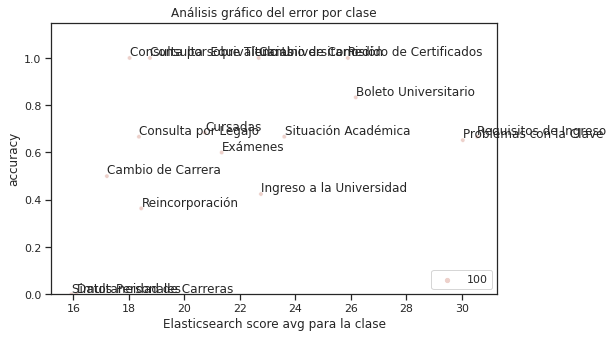

In [26]:
# Cargo las librerías y defino el paño blanco
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

# Ploteo el gráfico general
plt.figure(figsize=(8,5))
sns.scatterplot(data=df_error, x="score", y="accuracy", hue="count_train", size="count_train")

# Pongo los nombres de las clases
for i in range(df_error.shape[0]):

  # Filtro solo los puntos con más de N_ap apariciones
  N_ap = 30
  if df_error.count_train[i]>=N_ap:
    plt.text(x=df_error.score[i]+0.01,
             y=df_error.accuracy[i]+0.01,
             s=df_error.clase[i])

plt.title("Análisis gráfico del error por clase")           #title
# plt.xlim(df_error.score.min()-1,df_error.score.max()+1)   #set x limit
plt.ylim(0, df_error.accuracy.max()+0.15)                   #set y limit
plt.xlabel("Elasticsearch score avg para la clase")         #y label
plt.legend(loc='lower right')

## Referencias
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/ml-pipelines-using-scikit-learn-and-gridsearchcv-fe605a7f9e05